In [1]:
import os
import numpy as np
import random as rn
import matplotlib.pyplot as plt
from functools import partial

import tensorflow as tf
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda, Reshape

# Use Sample Datasets: mnist
# from tensorflow.keras.datasets.mnist import load_data

# Seed 고정: 재현성
seed = 777
rn.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
tf.compat.v1.set_random_seed(seed)


def sample_images(latent_dim, decoder):
    r, c = 5, 5
    # latent_dim, decoder = self.latent_dim, self.decoder

    z = np.random.normal(size=(r * c, latent_dim))
    gen_imgs = decoder.predict(z)

    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

In [3]:
class AdversarialAutoEncoder:
    def __init__(self):
        self.img_shape = None
        self.cols_num = None
        self.latent_dim = None
        self.adversarial_autoencoder = None
        self.encoder, self.decoder, self.discriminator = None, None, None
        # initializer 지정
        self.initializer = tf.compat.v1.keras.initializers.glorot_uniform(seed=seed)
        # Optimizer 지정
        self.optimizer = Adam(0.0002, 0.5)
        # LeakyReLU 함수 호출
        self.leaky_relu = partial(tf.nn.leaky_relu, alpha=0.2)

    def sample_z(self, args):
        latent_dim = self.latent_dim
        mu, log_var = args
        batch = K.shape(mu)[0]
        eps = K.random_normal(shape=(batch, latent_dim), mean=0., stddev=1.)
        return mu + K.exp(log_var / 2) * eps

    def build_discriminator(self, latent_dim):
        """Build Discriminator"""
        leaky_relu, initializer = self.leaky_relu, self.initializer
        input_discriminator = Input(shape=(latent_dim,), name='Discriminator_Input')
        mapped = Dense(512, activation=leaky_relu, kernel_initializer=initializer, name='Discriminator_M1')(
            input_discriminator)
        mapped = Dense(256, activation=leaky_relu, kernel_initializer=initializer, name='Discriminator_M2')(mapped)
        output_discriminator = Dense(1, activation='sigmoid', kernel_initializer=initializer,
                                     name='Discriminator_Output')(mapped)

        discriminator = Model(inputs=input_discriminator, outputs=output_discriminator, name="Discriminator")

        return discriminator

    def build_encoder(self, latent_dim, img_shape):
        """# Build Encoder"""
        deterministic = 1
        self.img_shape, self.latent_dim = img_shape, latent_dim      
        leaky_relu, initializer = self.leaky_relu, self.initializer

        input_encoder = Input(shape=img_shape, name="Encoder_Input")

        mapped = Flatten()(input_encoder)
        mapped = Dense(512, activation=leaky_relu, kernel_initializer=initializer, name='Encoder_M1')(mapped)
        mapped = Dense(256, activation=leaky_relu, kernel_initializer=initializer, name='Encoder_M2')(mapped)

        if deterministic:
            output_encoder = Dense(latent_dim)(mapped)
        else:
            z_mean = Dense(latent_dim, name="MeanOfZ")(mapped)
            z_sigma = Dense(latent_dim, name="SigmaOfZ")(mapped)
            output_encoder = Lambda(self.sample_z)([z_mean, z_sigma])

        encoder = Model(input_encoder, output_encoder, name='Encoder')

        return encoder

    def build_decoder(self, latent_dim, img_shape):
        self.latent_dim = latent_dim
        leaky_relu, initializer = self.leaky_relu, self.initializer

        input_decoder = Input(shape=(latent_dim,), name="Decoder_Input")
        
        mapped = Dense(256, activation=leaky_relu, kernel_initializer=initializer, name='Decoder_M1')(input_decoder)
        mapped = Dense(512, activation=leaky_relu, kernel_initializer=initializer, name='Decoder_M2')(mapped)
        
        output_decoder = Dense(np.prod(img_shape), activation='tanh')(mapped)
        output_decoder = Reshape(img_shape)(output_decoder)
        
        decoder = Model(input_decoder, output_decoder, name="Decoder")

        return decoder

    def build_model(self, cols_num):
        img_shape = (cols_num, 1, )         # image_data: (cols_num, row_num, )
        latent_dim = int(cols_num * 0.5)
        optimizer = self.optimizer

        # Build and compile the discriminator
        discriminator = self.build_discriminator(latent_dim)
        discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        # Build the encoder / decoder
        encoder = self.build_encoder(latent_dim, img_shape)
        decoder = self.build_decoder(latent_dim, img_shape)

        # The generator takes the image, encodes it and reconstructs it from the encoding
        input_data = Input(shape=img_shape)
        # Each Output
        encoded = encoder(input_data)
        reconstructed = decoder(encoded)
        # For the adversarial_autoencoder model we will only train the generator
        discriminator.trainable = False
        # The discriminator determines validity of the encoding
        validity = discriminator(encoded)
        # The adversarial_autoencoder model  (stacked generator and discriminator)
        adversarial_autoencoder = Model(input_data, [reconstructed, validity])
        adversarial_autoencoder.compile(loss=['mse', 'binary_crossentropy'],
                                        loss_weights=[0.999, 0.001],
                                        optimizer=optimizer)
        # Visualize adversarial_autoencoder Model
        adversarial_autoencoder.summary()

        self.encoder, self.decoder, self.discriminator = encoder, decoder, discriminator
        self.adversarial_autoencoder = adversarial_autoencoder
        return adversarial_autoencoder

    def fit(self, x, epochs=5000, batch_size=128, verbose=1):
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))  # shape: (batch_size, 1)
        fake = np.zeros((batch_size, 1))  # shape: (batch_size, 1)

        # Let's Train Adversial AutoEncoder Model
        history = []
        for epoch in range(epochs):
            # 1. Select a random batch of data
            idx = np.random.randint(0, x.shape[0], batch_size)
            imgs = x[idx]  # imgs.shape : (batch_size, input_dim)

            # 2. Train Discriminator
            latent_fake = self.encoder.predict(imgs)
            latent_real = np.random.normal(size=(batch_size, self.latent_dim))  # shape: (batch_size, latent_dim)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(latent_real, valid)
            d_loss_fake = self.discriminator.train_on_batch(latent_fake, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            #  2. Train Generator
            g_loss = self.adversarial_autoencoder.train_on_batch(imgs, [imgs, valid])
            # Plot the progress
            if verbose == 1:
                # verbose = 1 :progress bar
                if epoch % 10 == 0:
                    print("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (
                        epoch, d_loss[0], 100 * d_loss[1], g_loss[0], g_loss[1]))
                    print(f"{epoch}/{epochs}, imgs.shape", imgs.shape)
            else:
                # verbose = 0 :silent
                pass
            # if epoch % 50 == 0:
                # sample_images(latent_dim=self.latent_dim, decoder=self.decoder)
            history.append([epoch, d_loss[0], 100 * d_loss[1], g_loss[0], g_loss[1]])
        history = pd.DataFrame(history, columns=["Epochs", 'D Loss', 'D Acc', "G Loss", "MSE"])
        return history

    def predict(self, x):
        predict_value = self.adversarial_autoencoder.predict(x)
        return predict_value

In [4]:
# Load Data
(X_train, _), (X_test, _) = load_data()
# Scale the Data
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_test = (X_test.astype(np.float32) - 127.5) / 127.5

rows_num, cols_num = X_train.shape[0], X_train.shape[1]

In [5]:
aae = AdversialAutoEncdoer()
aae.build_model(cols_num=cols_num)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 Encoder (Functional)           (None, 14)           536846      ['input_1[0][0]']                
                                                                                                  
 Decoder (Functional)           (None, 28, 28)       537616      ['Encoder[0][0]']                
                                                                                                  
 Discriminator (Functional)     (None, 1)            139265      ['Encoder[0][0]']                
                                                                                              

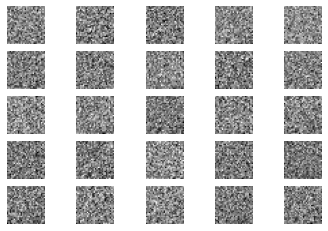

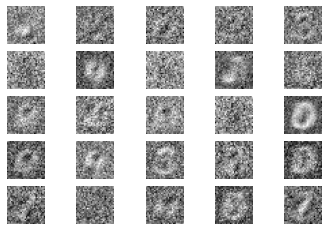

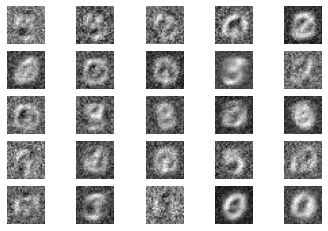

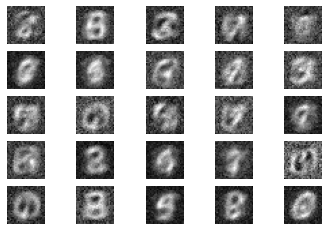

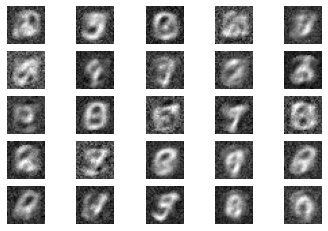

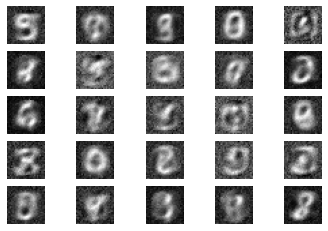

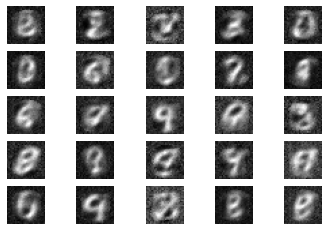

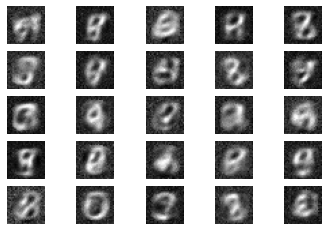

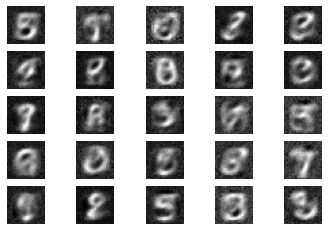

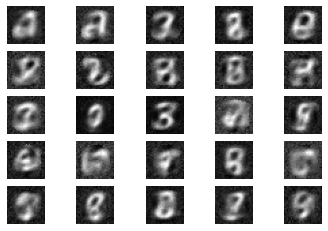

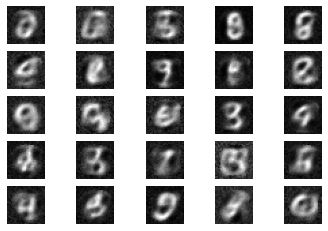

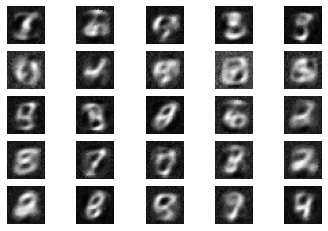

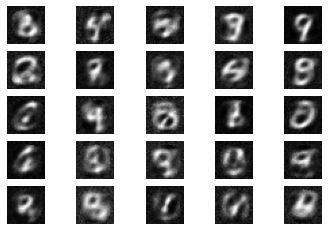

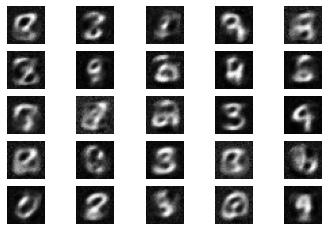

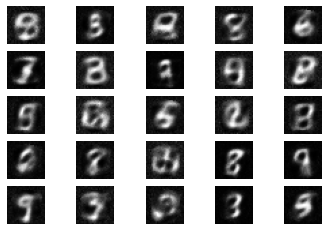

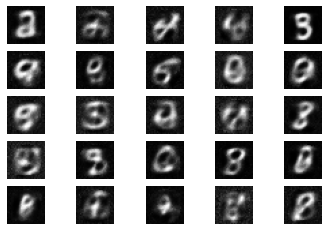

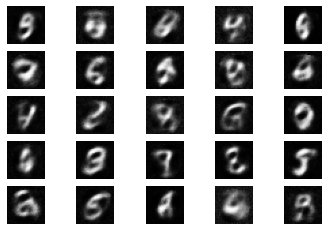

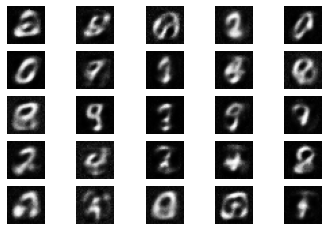

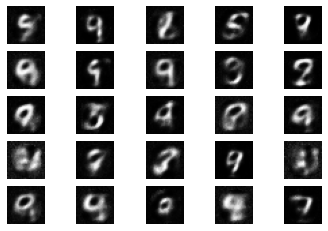

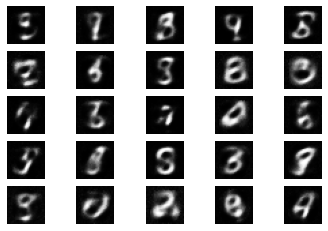

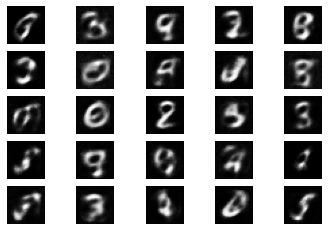

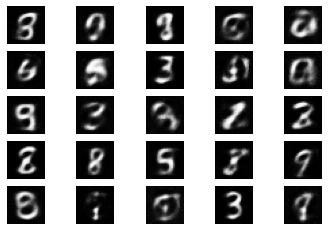

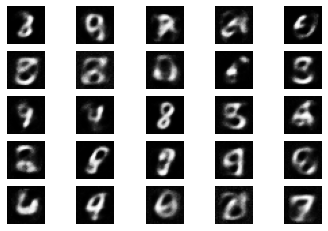

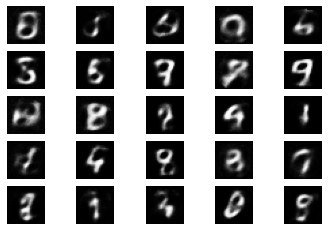

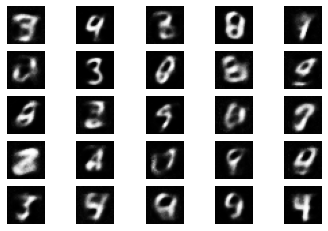

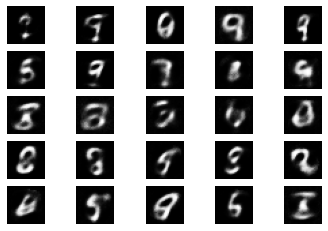

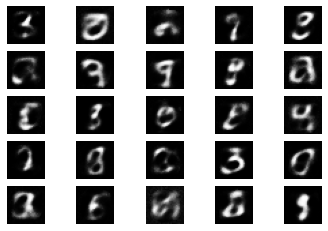

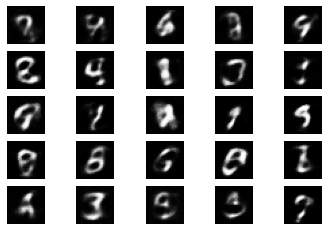

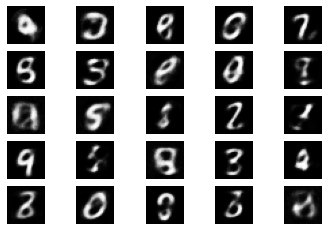

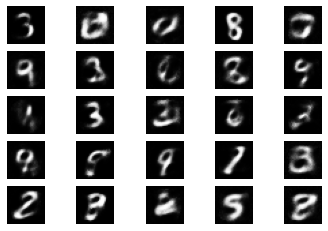

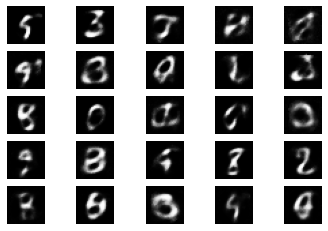

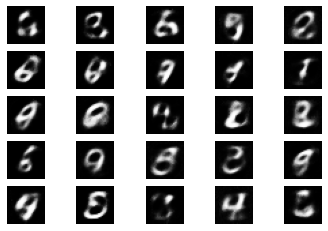

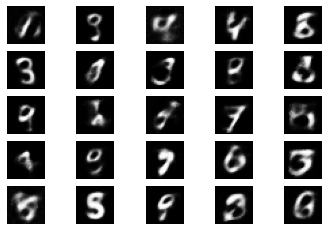

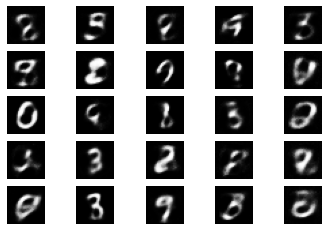

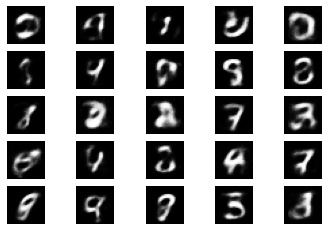

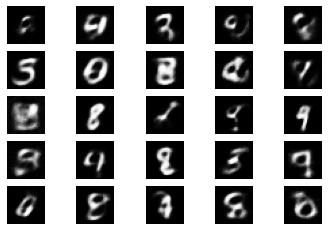

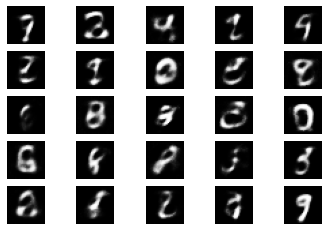

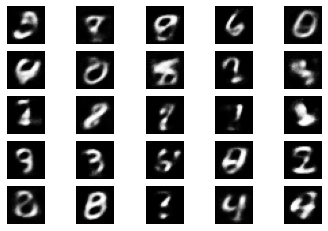

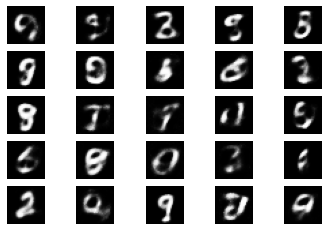

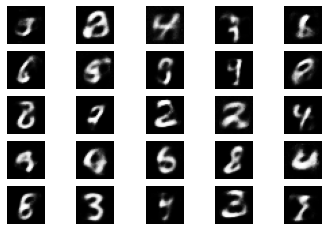

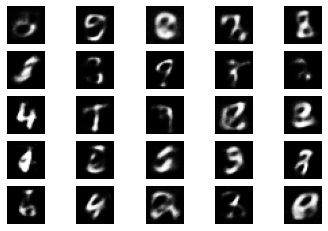

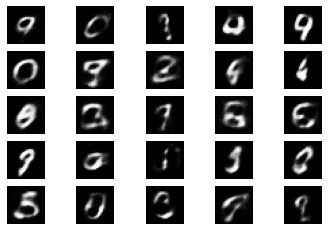

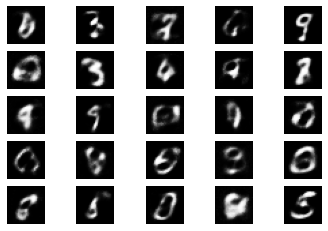

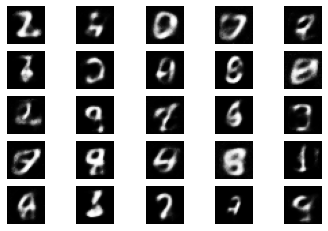

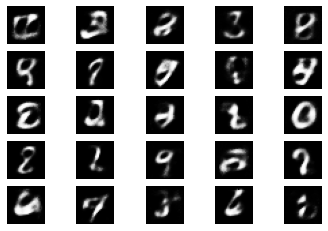

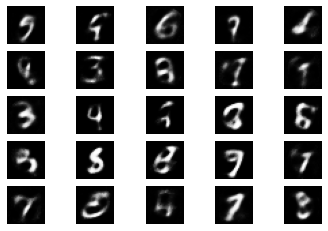

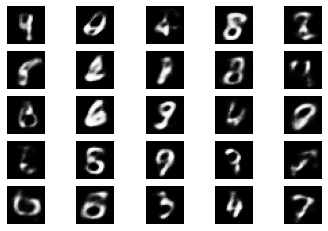

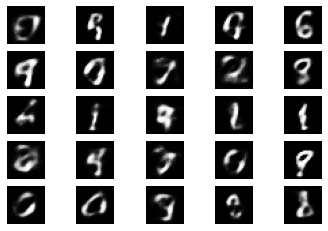

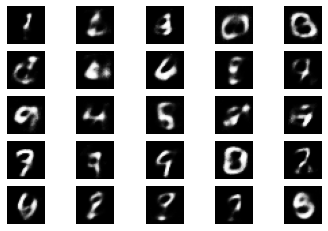

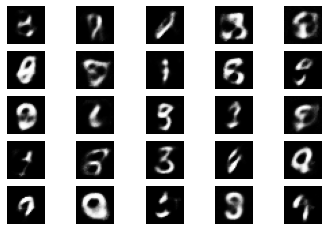

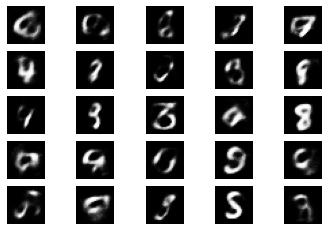

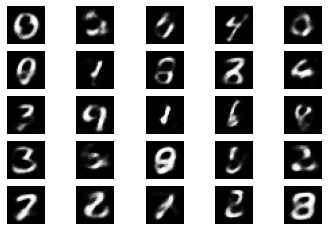

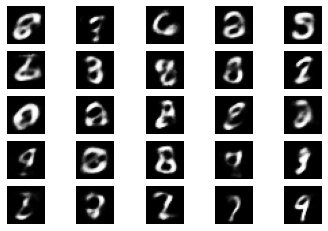

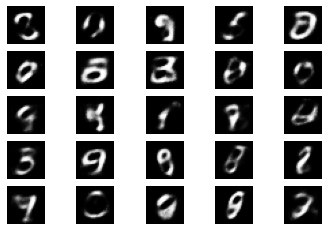

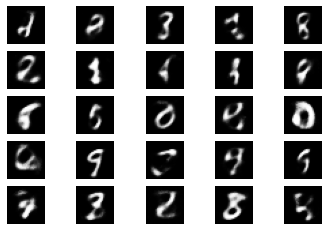

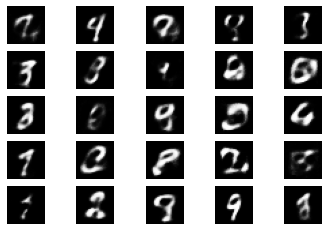

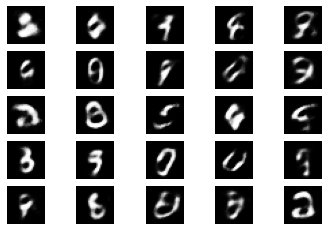

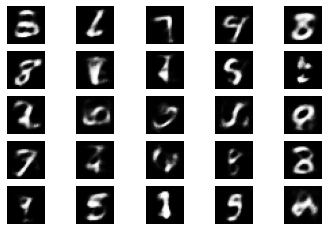

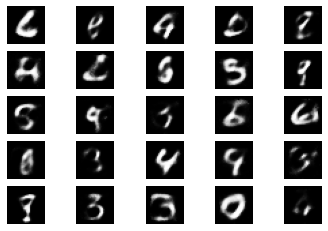

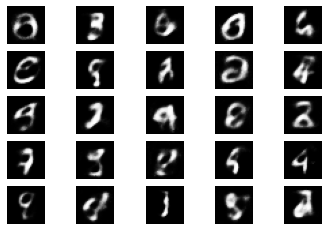

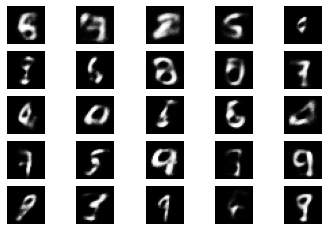

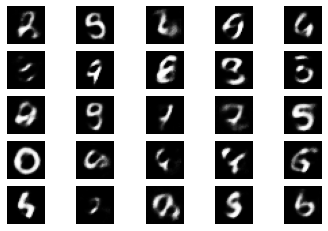

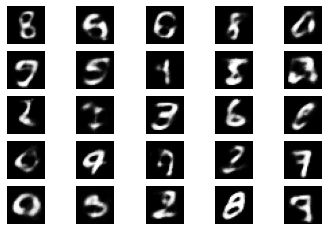

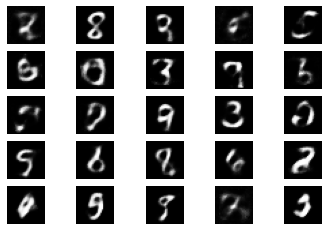

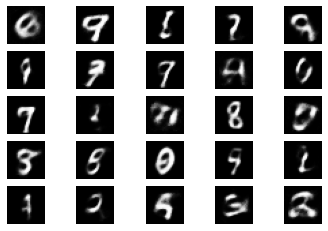

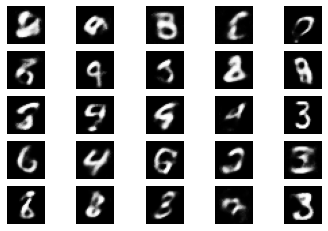

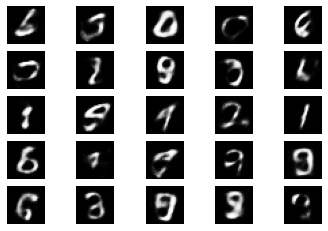

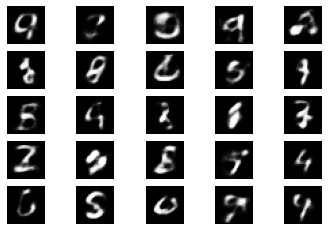

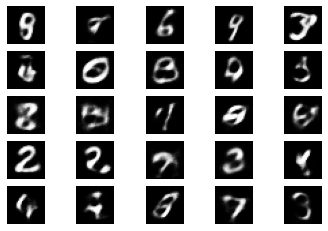

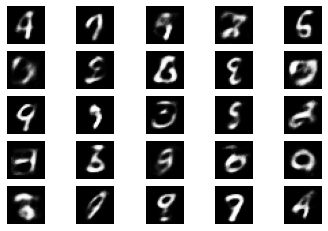

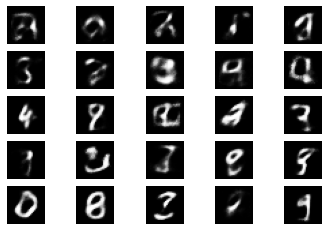

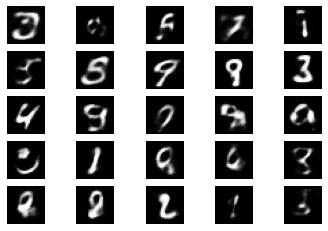

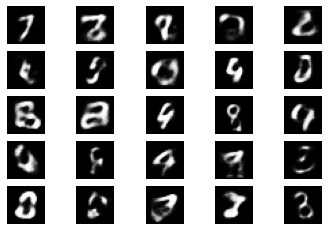

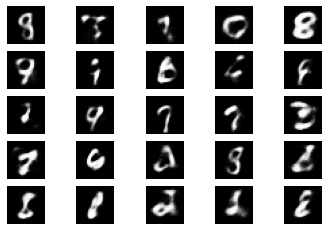

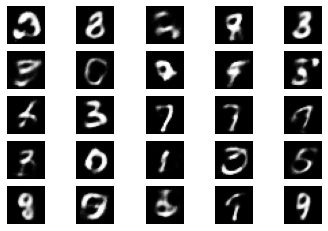

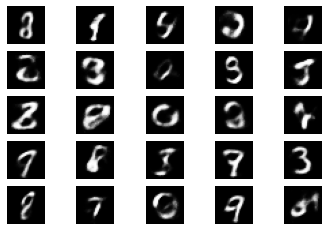

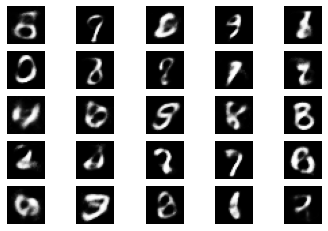

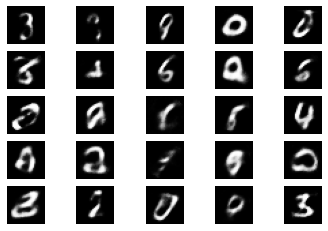

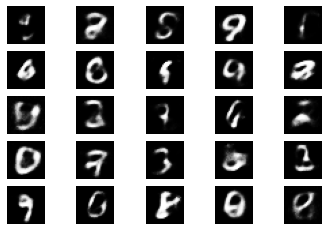

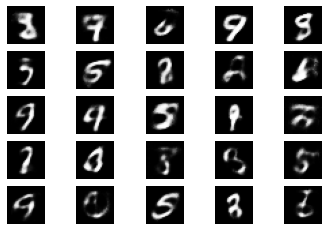

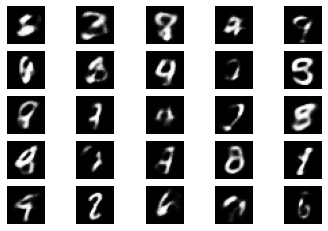

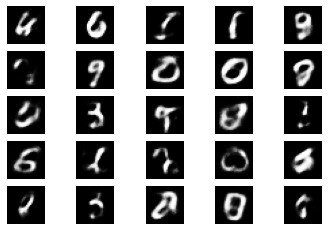

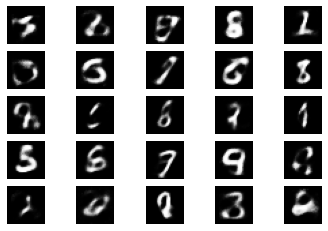

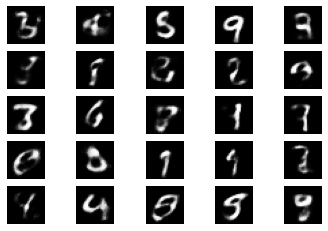

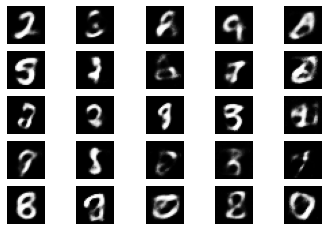

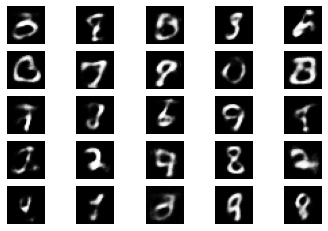

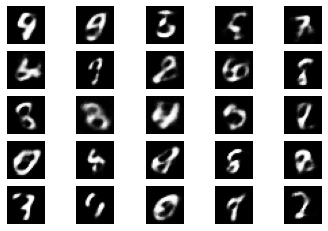

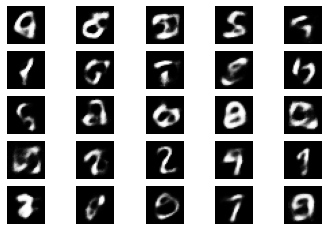

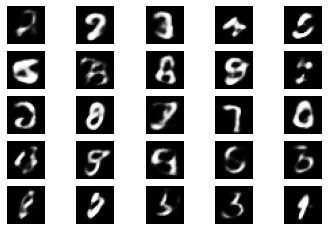

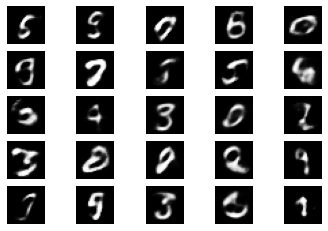

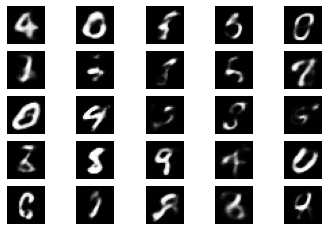

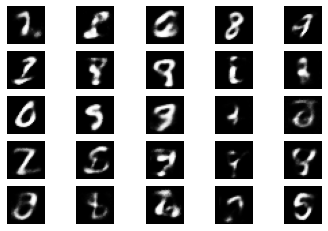

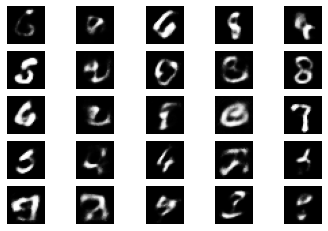

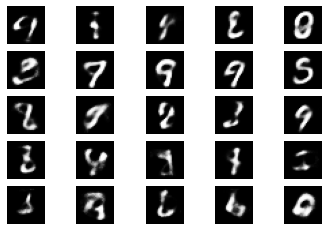

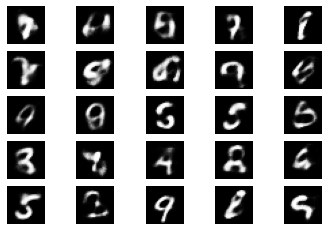

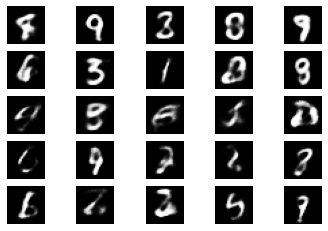

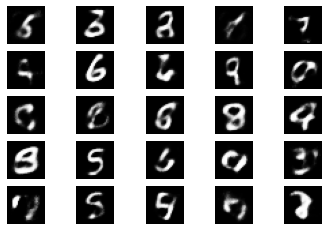

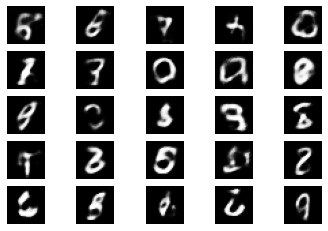

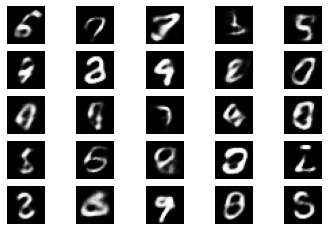

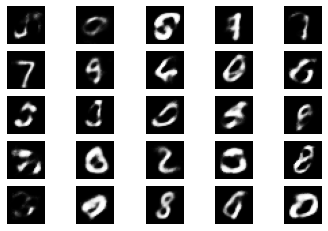

In [6]:
aae.fit(x=X_train, epochs=5000, batch_size=128, verbose=0)

In [7]:
train_pred = aae.predict(x=X_train)
test_pred = aae.predict(x=X_test)

In [8]:
X_train.shape, train_pred[0].shape

((60000, 28, 28), (60000, 28, 28))

Train Image


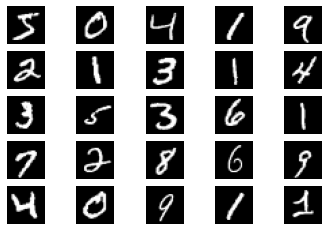

Train Pred Image


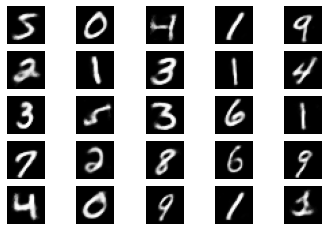

In [9]:
print("Train Image")
X_train_imgs = sample_images(gen_imgs=X_train)
print("Train Pred Image")
train_pred_imgs = sample_images(gen_imgs=train_pred[0])

Test Image


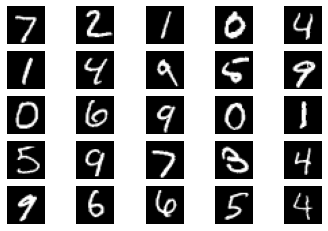

Test Pred Image


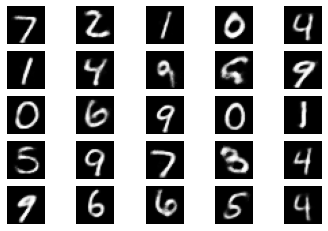

In [10]:
print("Test Image")
X_test_imgs = sample_images(gen_imgs=X_test)
print("Test Pred Image")
test_pred_imgs = sample_images(gen_imgs=test_pred[0])